# Úkol č. 3 - regrese

## Zdroje dat

  - Zdrojem dat může být soubor `LifeExpectancyData.csv` na course pages (originál zde: https://www.kaggle.com/kumarajarshi/life-expectancy-who).
  - Popis datasetu najdete na uvedené stránce s originálem datasetu.
  - Cílová (vysvětlovaná) proměnná se jmenuje `Life expectancy `.

nebo jeden z Vašich datasetů.

## Pokyny k vypracování

  1. Odeberte z dat body u kterých neznáte vysvětlovanou proměnnou.
  1. Rozdělte data na trénovací a testovací množinu.
  1. Proveďte základní průzkum dat a svá pozorování diskutujte. Na jeho základě adekvátně reagujte na problematické věci v datech (chybějící hodnoty, atd.) a vysvětlete motivaci k provedeným krokům.
  1. Aplikujte lineární a hřebenovou regresi a výsledky řádně vyhodnoťte:
      - K měření chyby použijte `mean_absolute_error`.
  1. Zkoumejte, jak byste mohli modely vylepšit:
      - Experimentujte s tvorbou nových příznaků (na základě těch dostupných).
      - Experimentujte se standardizací/normalizací dat.
      - Vyberte si hyperparametry modelů k ladění a najděte jejich nejlepší hodnoty.
      - Získané výsledky vždy řádně okomentujte.
  1. Použijte i jiné modely (alespoň jeden) ukazované v předmětu VZD či i jiné, pokud víte jak fungují.

## Poznámky k odevzdání

- Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body
- Deadline pro odevzdání je 15/5/2023 o půlnoci, odeslat na mail tichyon2@fit.cvut.cz

# Řešení

- regrese je metoda učení s učitelem (supervised learning), kde model učíme odhadovat hodnotu vysvětlované proměnné y na základě hodnot vektoru příznaků X
- na rozdíl od klasifikace proměnná y má spojitý obor hodnot  
- dataset "Life Expectancy (WHO)", který zde budu používat, obsahuje zdravotnická data z různých zemí po světě, shromážděna organizací WHO; úkolem je zjistit, jak vysvětlovaná proměnná "Life expectancy" závisí na hodnotách dalších 20 vysvětlujících proměnných (které nesou informaci o nemocnosti lidí v zemi, úmrtnosti a podobně)

In [182]:
import time
# variables
rd_seed = 333 # round(time.time() % (2^16)) # random seed to split data
# init, import basic libs fot data analytics and ploting
import warnings
warnings.filterwarnings('ignore')
import math
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích
%matplotlib inline 
# Matplotlib umožňuje změnit styl na jiný, než defaultní
matplotlib.style.use('ggplot')
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation (so 0.000 is printed as 0.)

In [183]:
# 0) read data from file, show basic information about data set
data = pd.read_csv("hw3/Life-Expectancy-Data.csv")
display(data.shape) 
display(data.head(10))
display(data.isnull().sum())
# if there are some string/object types, transform values to integers
string_cols = data.select_dtypes(['object']).columns # non numeric series
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes) # on this line we convert

(2938, 22)

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   
5  Afghanistan  2010  Developing              58.8            279.0   
6  Afghanistan  2009  Developing              58.6            281.0   
7  Afghanistan  2008  Developing              58.1            287.0   
8  Afghanistan  2007  Developing              57.5            295.0   
9  Afghanistan  2006  Developing              57.3            295.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   
5             74     0.01               79.679367         66.0      1989  ...   
6             77     0.01               56.762217         63.0      2861  ...   
7             80     0.03               25.873925         64.0      1599  ...   
8             82     0.02               10.910156         63.0      1141  ...   
9             84     0.03               17.171518         64.0      1990  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   
5   66.0               9.20         66.0        0.1  553.328940   2883167.0   
6   63.0               9.42         63.0        0.1  445.893298    284331.0   
7   64.0               8.33         64.0        0.1  373.361116   2729431.0   
8   63.0               6.73         63.0        0.1  369.835796  26616792.0   
9   58.0               7.43         58.0        0.1  272.563770   2589345.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   
5                   18.4                 18.4   
6                   18.6                 18.7   
7                   18.8                 18.9   
8                   19.0                 19.1   
9                   19.2                 19.3   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  
5                            0.448        9.2  
6                            0.434        8.9  
7                            0.433        8.7  
8                            0.415        8.4  
9                            0.405        8.1  

[10 rows x 22 columns]

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [184]:
# 1) remove those data points, where we dont know the 'Life expectancy' value
data = data.rename(columns={'Life expectancy ': 'la'})
null_count = data["la"].isnull().sum()
print("Number of rows with null values in 'Life expectancy' column:", null_count)
data = data.dropna(subset=['la'])
null_count = data["la"].isnull().sum()
print("Number of rows with null values in 'Life expectancy' column:", null_count)

Number of rows with null values in 'Life expectancy' column: 10
Number of rows with null values in 'Life expectancy' column: 0


In [185]:
# 3) data overview & preprocessing
nan_counts = data.isnull().sum()
print("Original data change to -1:")
display(nan_counts)
data = data.fillna(-1) # regression would have problem with null values -> we change them to -1
print("After change to -1:")
nan_counts = data.isnull().sum()
display(nan_counts)

# 2) split data to train and test sets
from sklearn.model_selection import train_test_split
def split_data(d):
    X, X_test, Y, Y_test = train_test_split(data.drop(columns = ['la']), data['la'], test_size=0.25, random_state=rd_seed)
    print('Train X shape', X.shape)
    print('Test X shape', X_test.shape)
    print(type(X))
    return X, X_test, Y, Y_test

X, X_test, Y, Y_test = split_data(data)

Original data change to -1:


Country                              0
Year                                 0
Status                               0
la                                   0
Adult Mortality                      0
infant deaths                        0
Alcohol                            193
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                32
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                443
Population                         644
 thinness  1-19 years               32
 thinness 5-9 years                 32
Income composition of resources    160
Schooling                          160
dtype: int64

After change to -1:


Country                            0
Year                               0
Status                             0
la                                 0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64

Train X shape (2196, 21)
Test X shape (732, 21)
<class 'pandas.core.frame.DataFrame'>


### Lineární regrese
- model lineární regrese předpokládá lineární závislost vysvětlovanné proměnné na příznacích ve vektoru X
- LR se snaží najít vektor vah (pro přenásobení příznaků X), intercept (výchozí hodnota y pro X = 0) a náhodnou odchylku e

Weights vector, each one weight multiplies value of one column.
[ 0.0064   0.07212 -2.70059 -0.02122  0.12663  0.13491  0.00004  0.00543
 -0.00002  0.05766 -0.09375  0.02518 -0.02149  0.03141 -0.46064  0.00005
  0.      -0.11214 -0.02189 -2.99382  0.674  ]


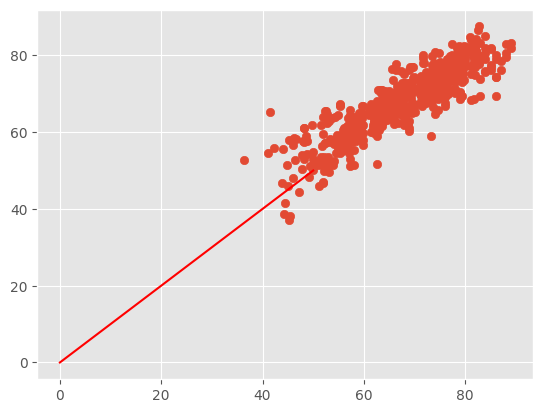

MAE: 1.830517676599307


In [186]:
# 4) Aplikujte lineární a hřebenovou regresi a výsledky řádně vyhodnoťte (k měření chyby použijte `mean_absolute_error`):
# a) lineární regrese (linear regression)
# lineární regrese
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def linear_regression_fc(X, X_test, Y, Y_test):
    clf = LinearRegression()
    clf.fit(X,Y) # the model for linear regression learns
    print("Weights vector, each one weight multiplies value of one column.")
    print(clf.coef_)
    Yth = clf.predict(X_test) # tries to predict Y value based of columns in X using the w weights
    plt.scatter(Y_test, Yth)
    plt.plot([0,50], [0,50], 'r')
    plt.show()
    print('MAE:', np.sqrt(mean_absolute_error(Yth, np.array(Y_test)))) # information about deviation of prediction from real value
linear_regression_fc(X, X_test, Y, Y_test)


In [187]:
# b) hřebenová regrese (ridge regression)
from typing import Callable, Tuple
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

def ridge_model(x, y) -> Callable[[float], float]:
    def inner(alpha: float) -> float:
        model = Ridge(alpha=alpha)
        return -np.mean(
            cross_val_score(model, x, y, cv=5, scoring='neg_mean_absolute_error')
        )
    
    return inner

from scipy import optimize

def get_ridge_model(X, y) -> Tuple[Ridge, float]:
    opt_function = ridge_model(X, y)
    
    opt_alpha = optimize.minimize_scalar(
        opt_function, options={'maxiter': 30}, method='bounded', bounds=(0.1, 400)
    )
    
    best_model = Ridge(alpha=opt_alpha.x)
    best_model.fit(X, y)
    return best_model, opt_alpha.x

def plot_prediction_results(title, true, predicted):
    plt.scatter(true, predicted)
    plt.xlabel("true y")
    plt.ylabel("predicted y")
    plt.title(f"Visualization of predictions | {title} | MAE: {mean_absolute_error(true, np.array(predicted))}")

Best alpha value: 23.837454243473253


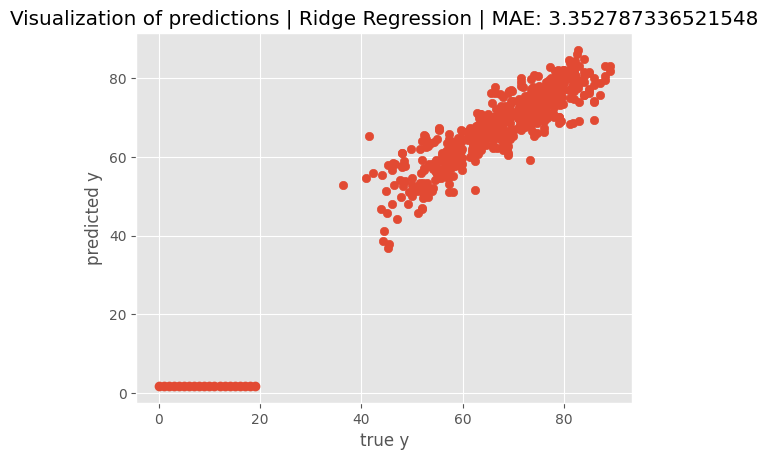

In [188]:
def ridge_regression_fc(X, X_test, Y, Y_test):
    X_train = X
    y_train = Y
    opt_function = ridge_model(X_train, y_train)
    alphas = list(range(20))
    mse_errors = np.sqrt([opt_function(alpha) for alpha in alphas])
    plt.plot(alphas,mse_errors, 'o-')
    plt.title("Visualization of MAE for a range of lambdas")
    plt.xlabel("Lambda value")
    plt.ylabel("MAE")

    y_test = Y_test
    rr_model, best_alpha = get_ridge_model(X_train, y_train)
    rr_pred = rr_model.predict(X_test)
    rr_coef = rr_model.coef_
    rr_error = np.sqrt(mean_absolute_error(y_test, rr_pred))
    print("Best alpha value:", best_alpha)
    plot_prediction_results("Ridge Regression", y_test, rr_pred)

ridge_regression_fc(X, X_test, Y, Y_test)

Best alpha value: 23.837454243473253


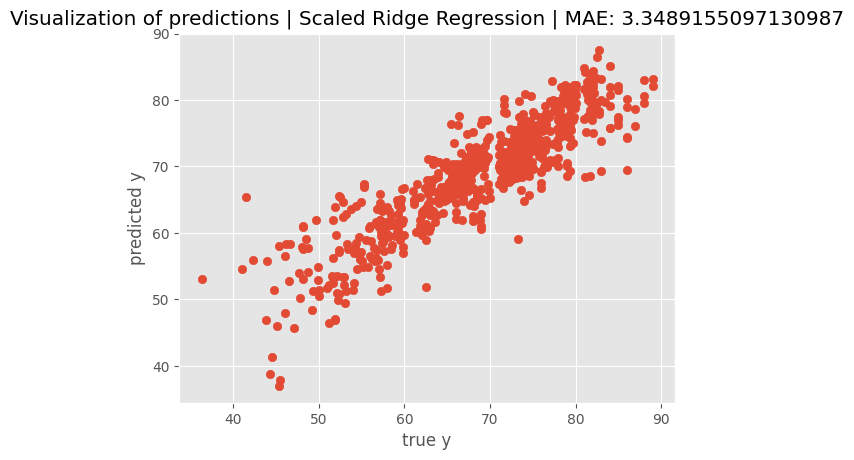

In [189]:
# 5) standardizace příznaků
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaled_model, scaled_best_alpha = get_ridge_model(X_train_scaled, y_train)

scaled_rr_pred = scaled_model.predict(X_test_scaled)
scaled_rr_coef = scaled_model.coef_
scaled_rr_error = np.sqrt(mean_absolute_error(y_test, scaled_rr_pred))

print("Best alpha value:", best_alpha)

plot_prediction_results("Scaled Ridge Regression", y_test, scaled_rr_pred)

Train X shape (2196, 22)
Test X shape (732, 22)
<class 'pandas.core.frame.DataFrame'>
Weights vector, each one weight multiplies value of one column.
[ 0.00642  0.07192 -2.69609 -0.02123  0.12639  0.13553  0.00004  0.00545
 -0.00002  0.05767 -0.09361  0.02519 -0.02163  0.03138 -0.46031  0.00005
  0.      -0.11079 -0.02404 -2.99719  0.67496  0.00001]


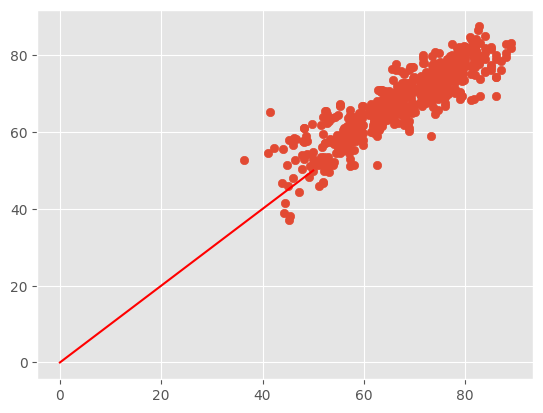

MAE: 1.8305509393881754
Best alpha value: 22.12159385015959


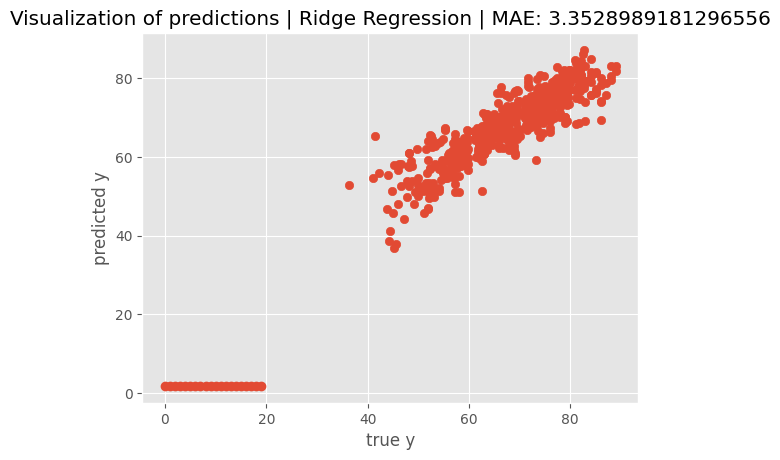

In [190]:
# 5) creating new feature
def experiment_fc(d):
    X, X_test, Y, Y_test = split_data(d)
    linear_regression_fc(X, X_test, Y, Y_test)
    ridge_regression_fc(X, X_test, Y, Y_test)

data["adult-children-deaths"] = (data["infant deaths"] / data["Alcohol"])
experiment_fc(data)


### Lasso Regression

Train X shape (2196, 22)
Test X shape (732, 22)
<class 'pandas.core.frame.DataFrame'>
-120.13353325707585
[ 0.00722  0.09066 -1.67241 -0.02194  0.12569  0.20279  0.00003  0.00346
 -0.00001  0.0636  -0.09334  0.02801 -0.00322  0.0333  -0.45877  0.00006
 -0.      -0.11394 -0.02395 -0.1409   0.40061  0.00001]


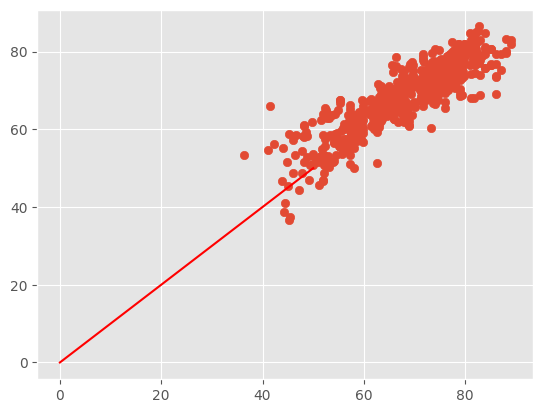

In [191]:
# 6) using some other regression technique
from sklearn import linear_model
X, X_test, Y, Y_test = split_data(data)
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X, Y)
print(clf.intercept_)
print(clf.coef_)
# predict and display
Yth = clf.predict(X_test)
plt.scatter(Y_test, Yth)
plt.plot([0,50], [0,50], 'r')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e90e9d6e-b1c2-41b4-8177-e94120d467e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>